# Load Dataset

Initializing a few parameters required for the image dataset preprocessing.

In [ ]:
!unzip data.zip


unzip:  cannot find or open data.zip, data.zip.zip or data.zip.ZIP.


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import PIL
from PIL import Image
from skimage.color import rgb2gray
from scipy import ndimage as ndi
import cv2
import os
from os import listdir
from sklearn.utils import shuffle
import tensorflow as tf
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization,Input
from keras import Model
from tensorflow.keras.optimizers import SGD
from keras import regularizers
from keras.callbacks import ModelCheckpoint

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


We use the function `convert_image_to_array` to resize an image to the size `DEFAULT_IMAGE_SIZE` we defined above.


In [ ]:
directory_root = '/content/Data Set/train'
print("[INFO] Loading Training images...")
root_dir = listdir(directory_root)
print("\nTotal Folder : ",len(root_dir))

for plant_folder in root_dir :
  print("\n\nLoading Folder : ",plant_folder)
  plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
  total_images = len(plant_disease_folder_list)
  print("Total Images found : ",total_images)


[INFO] Loading Training images...

Total Folder :  4


Loading Folder :  PET
Total Images found :  118


Loading Folder :  HDPE
Total Images found :  166


Loading Folder :  LDPA
Total Images found :  53


Loading Folder :  PP
Total Images found :  242


In [ ]:
directory_root = '/content/Data Set/val'
print("[INFO] Loading Training images...")
root_dir = listdir(directory_root)
print("\nTotal Folder : ",len(root_dir))

for plant_folder in root_dir :
  print("\n\nLoading Folder : ",plant_folder)
  plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
  total_images = len(plant_disease_folder_list)
  print("Total Images found : ",total_images)


[INFO] Loading Training images...

Total Folder :  4


Loading Folder :  PET
Total Images found :  46


Loading Folder :  HDPE
Total Images found :  50


Loading Folder :  LDPA
Total Images found :  17


Loading Folder :  PP
Total Images found :  53


In [ ]:

list_classes = os.listdir('/content/Data Set/train')
list_classes

['PET', 'HDPE', 'LDPA', 'PP']

<h1> Image Preprocessing </h1>

In [ ]:
# image preprocessing
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator()
                                  #  rescale=1./255,
                                  #  shear_range=0.2,
                                  #  zoom_range=0.2,
                                  #  width_shift_range=0.2,
                                  #  height_shift_range=0.2,
                                  #  fill_mode='nearest')

test_datagen = ImageDataGenerator()
# rescale=1./255

batch_size = 256
base_dir = '/content/Data Set'

training_set = train_datagen.flow_from_directory(base_dir+'/train',
                                                 batch_size=batch_size,
                                                 class_mode='categorical')

test_set = test_datagen.flow_from_directory(base_dir+'/val',
                                            batch_size=batch_size,
                                            class_mode='categorical')


Found 579 images belonging to 4 classes.
Found 166 images belonging to 4 classes.


In [ ]:
class_dict = training_set.class_indices
print(class_dict)

{'HDPE': 0, 'LDPA': 1, 'PET': 2, 'PP': 3}


In [ ]:
li = list(class_dict.keys())
print(li)

['HDPE', 'LDPA', 'PET', 'PP']


In [ ]:
train_num = training_set.samples
test_num = test_set.samples

In [ ]:
train_num, test_num

(579, 166)



```
# This is formatted as code
```

# Augment and Split Dataset <h1> VGG 16 Model Architecture </h1>

In [ ]:
from keras.applications.vgg16 import VGG16

In [ ]:
in_shape=(256, 256, 3)
out_shape=4

vgg_model = VGG16(include_top=False, input_shape=in_shape)
for layer in vgg_model.layers:
  layer.trainable = False

# allow last vgg block to be trainable
vgg_model.get_layer('block5_conv1').trainable = True
vgg_model.get_layer('block5_conv2').trainable = True
vgg_model.get_layer('block5_conv3').trainable = True
vgg_model.get_layer('block5_pool').trainable = True

# add new classifier layers
flat1 = Flatten()(vgg_model.layers[-1].output)
fcon1 = Dense(4096, activation='relu', kernel_initializer='he_uniform')(flat1)
fdrop1 = Dropout(0.25)(fcon1)
fbn1 = BatchNormalization()(fdrop1)
fcon2 = Dense(4096, activation='relu', kernel_initializer='he_uniform')(fbn1)
fdrop2 = Dropout(0.25)(fcon2)
fbn2 = BatchNormalization()(fdrop2)
output = Dense(out_shape, activation='softmax')(fbn2)

# define new model
vgg_model = Model(inputs=vgg_model.inputs, outputs=output)

# compile model
opt = SGD(lr=0.01, momentum=0.9,decay=0.005)
vgg_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

vgg_model.summary()


58900480/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                              

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


# Build Model


Defining the hyperparameters of the plastic_detection classification model.

In [ ]:
# checkpoint
from keras.callbacks import ModelCheckpoint
weightpath = "VGG_Best_Weights.hdf5"
checkpoint = ModelCheckpoint(weightpath, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=True, mode='max')
callbacks_list = [checkpoint]



# Train Model


```
# This is formatted as code
```



In [ ]:
#fitting images to AlexNet
history = vgg_model.fit_generator(training_set,
                         steps_per_epoch=train_num//batch_size,
                         validation_data=test_set,
                         epochs=30,
                         validation_steps=test_num//batch_size,
                         callbacks=callbacks_list)
#saving model
filepath= "VGGModel.hdf5"
vgg_model.save(filepath)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/30
2/2 [==============================] - 65s 47s/step - loss: 1.5009 - accuracy: 0.4706
Epoch 2/30
2/2 [==============================] - 5s 3s/step - loss: 0.6075 - accuracy: 0.7802
Epoch 3/30
2/2 [==============================] - 5s 1s/step - loss: 0.3068 - accuracy: 0.8978
Epoch 4/30
2/2 [==============================] - 5s 3s/step - loss: 0.2291 - accuracy: 0.9257
Epoch 5/30
2/2 [==============================] - 5s 1s/step - loss: 0.1805 - accuracy: 0.9381
Epoch 6/30
2/2 [==============================] - 7s 3s/step - loss: 0.1757 - accuracy: 0.9453
Epoch 7/30
2/2 [==============================] - 5s 3s/step - loss: 0.0683 - accuracy: 0.9752
Epoch 8/30
2/2 [==============================] - 5s 3s/step - loss: 0.0784 - accuracy: 0.9721
Epoch 9/30
2/2 [==============================] - 5s 3s/step - loss: 0.0327 - accuracy: 0.9907
Epoch 10/30
2/2 [==============================] - 5s 1s/step - loss: 0.0450 - accuracy: 0.9814
Epoch 11/30
2/2 [==============================

**bold text**# Train Model


We initialize Adam optimizer with learning rate and decay parameters. 

Also, we choose the type of loss and metrics for the model and compile it for training.

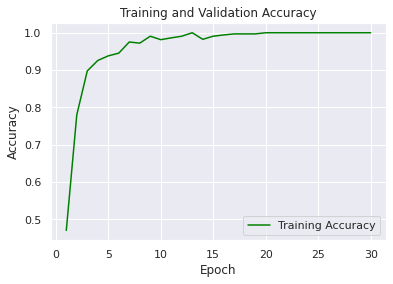

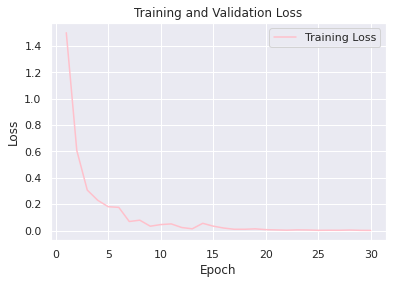

In [ ]:
#plotting training values
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

acc = history.history['accuracy']
loss = history.history['loss']
epochs = range(1, len(loss) + 1)

#accuracy plot
plt.plot(epochs, acc, color='green', label='Training Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.figure()
#loss plot
plt.plot(epochs, loss, color='pink', label='Training Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
list_classes

['PET', 'HDPE', 'LDPA', 'PP']

In [ ]:
from keras.preprocessing import image
li = list_classes
def process_img(image_path, model):
  # predicting an image
  new_img = image.load_img(image_path, target_size=(256, 256))
  img = image.img_to_array(new_img)
  img = np.expand_dims(img, axis=0)
  img = img/255

  print("Following is our prediction:")
  prediction = model.predict(img)
  print(prediction)
  # decode the results into a list of tuples (class, description, probability)
  # (one such list for each sample in the batch)
  d = prediction.flatten()
  j = d.max()
  for index,item in enumerate(d):
      if item == j:
          class_name = li[index]
          print(class_name)

          plt.figure(figsize = (4,4))
          plt.imshow(new_img)
          plt.axis('off')
          plt.title(class_name)
          plt.show()

In [ ]:
VGGModel = load_model("VGGModel.hdf5")


Following is our prediction:
[[3.324780e-04 9.075887e-03 2.253715e-02 9.680544e-01]]
PP


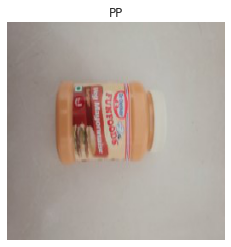

Following is our prediction:
[[3.6446916e-04 9.4191357e-03 1.9664338e-02 9.7055209e-01]]
PP


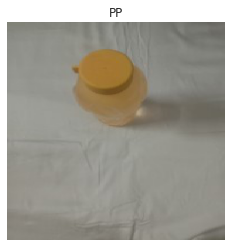

Following is our prediction:
[[3.4648401e-04 1.0586518e-02 2.0923989e-02 9.6814305e-01]]
PP


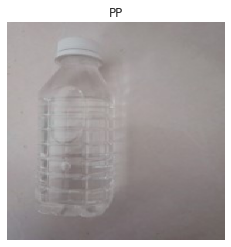

Following is our prediction:
[[2.6992743e-04 8.0905790e-03 1.5178612e-02 9.7646081e-01]]
PP


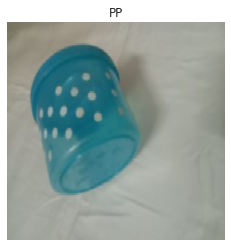

In [ ]:
while True:
    path = input('\n\n\nEnter Image Path : ').replace('"',"")
    process_img(path, VGGModel)

In [ ]:
VGGModel.evaluate(test_set)